# IUM-TWEB Jupyter Notebooks 2 : Visualisation

## Import necessary library

In [437]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import geopandas as gpd
from IPython.display import display, HTML

## Load the PQSL data from the Pickle file

In [438]:
with open('data/dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

## Access individual DataFrames

In [439]:
actor_df = dataframes['actor']
country_df = dataframes['country']
crew_df = dataframes['crew']
genre_df = dataframes['genre']
language_df = dataframes['language']
movie_df = dataframes['movie']
poster_df = dataframes['poster']
release_df = dataframes['release']
studio_df = dataframes['studio']
theme_df = dataframes['theme']


# Movie analysis
First, we look at the structure of the data to be processed

In [440]:
print("Number of rows and columns of movies dataframe: ",movie_df.shape)
print("There are therefore", movie_df.shape[0], "films available")

Number of rows and columns of movies dataframe:  (941595, 7)
There are therefore 941595 films available


In [441]:
movie_df.dtypes

id               int64
name            object
date           float64
tagline         object
description     object
minute         float64
rating         float64
dtype: object

## Convert data

Dates and minutes are in float, which shouldn't be the case, so we convert them to process them later.

In [442]:
movie_df = movie_df[movie_df['minute'].notna()].copy()
movie_df['minute'] = movie_df['minute'].astype('int')

movie_df = movie_df[movie_df['date'].notna()].copy()
movie_df['date'] = movie_df['date'].astype('int')

## Convertion verification

In [443]:
movie_df.dtypes

id               int64
name            object
date             int32
tagline         object
description     object
minute           int32
rating         float64
dtype: object

Now that we have the right type of data for data analysis, let's move on to analysis.
The first question I ask myself is
## Are the films in the database recent?
To answer this question I will only use dates that are not null and calculate the median 

In [444]:
non_null_dates = movie_df['date'].dropna()

non_null_dates.describe()

count    711153.000000
mean       1999.215612
std          26.923913
min        1874.000000
25%        1987.000000
50%        2010.000000
75%        2019.000000
max        2030.000000
Name: date, dtype: float64

In [445]:
median_date = non_null_dates.median()
print("The median year of the movies is:", int(median_date))

The median year of the movies is: 2010


## Visualization of the year's films

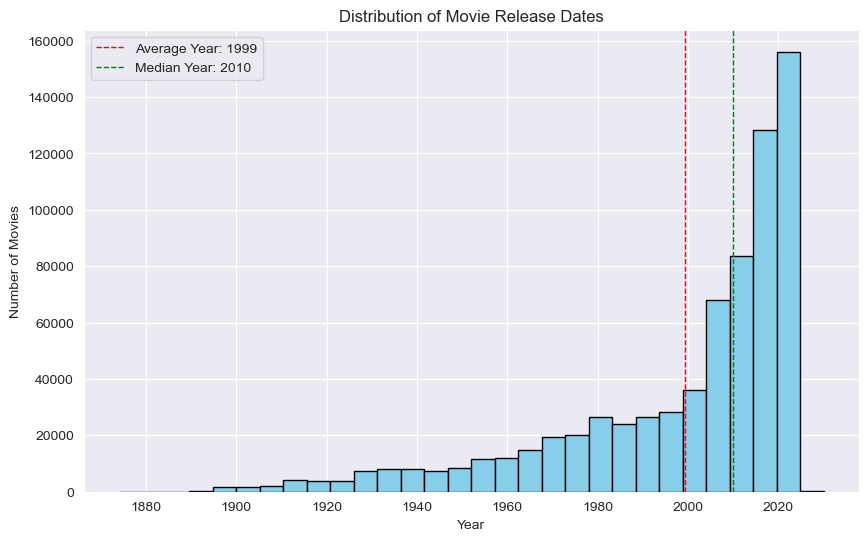

In [446]:
plt.figure(figsize=(10, 6))
plt.hist(non_null_dates, bins=30, color='skyblue', edgecolor='black')
plt.axvline(non_null_dates.mean(), color='red', linestyle='dashed', linewidth=1, label=f'Average Year: {int(non_null_dates.mean())}')
plt.axvline(median_date, color='green', linestyle='dashed', linewidth=1, label=f'Median Year: {int(median_date)}')
plt.title("Distribution of Movie Release Dates")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

The films are relatively recent, but what impresses me most is their sheer number.   
Then I asked myself a question.
# How long would it take to watch all these movies ?
To do this, I began by analyzing the minutes column of a movie

In [447]:
non_null_minutes = movie_df['minute'].dropna()
non_null_minutes.describe()

count    711153.000000
mean         67.516003
std         159.327639
min           1.000000
25%          15.000000
50%          66.000000
75%          93.000000
max       72000.000000
Name: minute, dtype: float64

In [448]:
print(f"The global average duration of movies is {non_null_minutes.mean():.2f} minutes.")
print(f"And the total duration of all these films are : {non_null_minutes.sum():.2f} minutes.")

The global average duration of movies is 67.52 minutes.
And the total duration of all these films are : 48014208.00 minutes.


This value doesn't mean much to us, so I'm going to represent it in days.
##  How many days to view all films ?

In [449]:
total_minutes = non_null_minutes.sum()

total_days = total_minutes / (24 * 60)
years = int(total_days // 365)
remaining_days = total_days % 365
months = int(remaining_days // 30)
days = int(remaining_days % 30)

print(f"It would take approximately {years} years, {months} months, and {days} days to watch all the movies.")
print("Good luck !!!")

It would take approximately 91 years, 4 months, and 8 days to watch all the movies.
Good luck !!!


I'd like to know more about these films: 
## What are their respective genres and how many films belong to each genre?

In [450]:
unique_genre = genre_df['genre'].unique()
genre_number = len(unique_genre)

print(f"Number of genres : {genre_number}")
print(unique_genre)

Number of genres : 19
['Comedy' 'Adventure' 'Thriller' 'Drama' 'Science Fiction' 'Action'
 'Music' 'Romance' 'History' 'Crime' 'Animation' 'Mystery' 'Horror'
 'Family' 'Fantasy' 'War' 'Western' 'TV Movie' 'Documentary']


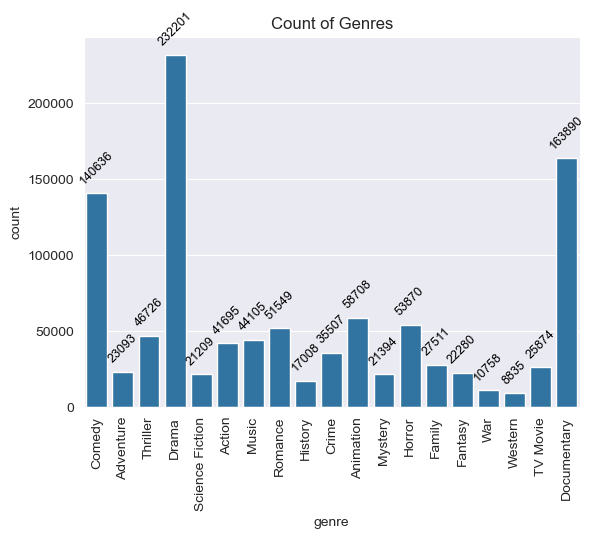

In [451]:
# Add count values on top of each bar
def add_count_on_bars(ax):
    # Add count values on top of each bar
    for p in ax.patches:
     ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points', rotation=45)

ax = sns.countplot(x='genre', data=genre_df)
plt.title('Count of Genres')
plt.xticks(rotation=90)
add_count_on_bars(ax)
plt.show()

Now I want that depending on the genre we like we can see how many are well rated
# Count the number of 1, 2, 3, 4, 5 stars per genre

In [452]:
# Merge the movie and genre dataframes
merged_df = pd.merge(movie_df, genre_df, left_on='id', right_on='id', how='inner')

# Round the rating values to the nearest 1, 2, 3, 4, or 5
merged_df['rounded_rating'] = merged_df['rating'].round()

# Map the rounded values to star labels
merged_df['rating_label'] = merged_df['rounded_rating'].map({
    1.0: "1 star",
    2.0: "2 stars",
    3.0: "3 stars",
    4.0: "4 stars",
    5.0: "5 stars"
})

# Group by genre and rating label to count occurrences
grouped_data = merged_df.groupby(['genre', 'rating_label']).size().reset_index(name='count')

# Calculate percentage of each star rating per genre
grouped_data['percentage'] = (
    grouped_data.groupby('genre')['count']
    .apply(lambda x: 100 * x / x.sum())
    .values  # Ensure alignment with grouped_data
)

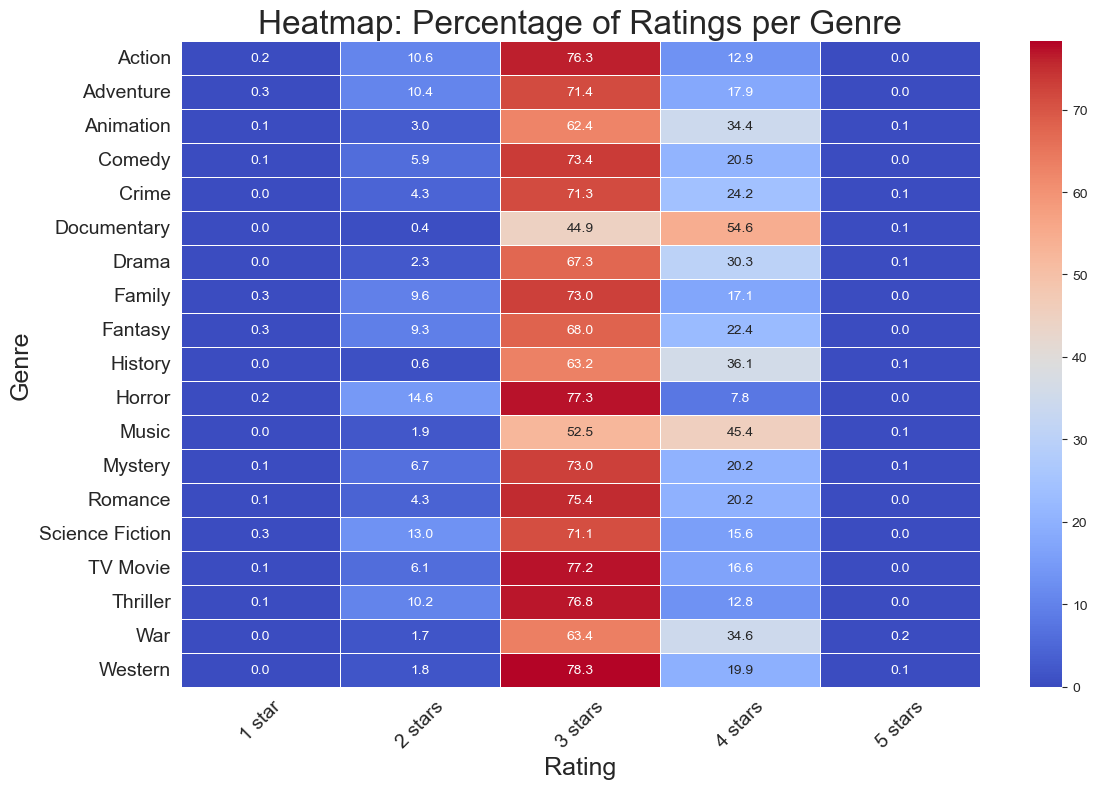

In [453]:
# Pivot the data to create a matrix suitable for a heatmap
heatmap_data = grouped_data.pivot(index='genre', columns='rating_label', values='percentage').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5
)
plt.title("Heatmap: Percentage of Ratings per Genre", fontsize=24)
plt.xlabel("Rating", fontsize=18)
plt.ylabel("Genre", fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


People in general are looking for well-rated movies to watch, so I'm interested in these films
# Movies with 5 stars
I recommend watching these movies.  
Pick one based on your favorite genre and read the description to find the film that interests you most !

In [454]:
# Filter the DataFrame for movies with 5 stars
five_star_movies = merged_df[merged_df['rounded_rating'] == 5]

# Add additional information about movies (including tagline, date, description, minute, and rating)
five_star_movies_info = five_star_movies[['genre', 'name', 'date', 'tagline', 'description', 'minute', 'rating']]

# Replace NaN values with "null" for proper display in hover data
five_star_movies_info = five_star_movies_info.fillna("null")

# Wrap the description to limit line length
def wrap_text(text, width=50):
    if text == "null":
        return text
    return '<br>'.join([text[i:i + width] for i in range(0, len(text), width)])
five_star_movies_info['description'] = five_star_movies_info['description'].apply(wrap_text)

In [455]:
# Prepare data for sunburst
sunburst_data = five_star_movies_info.explode('name')

# Create a sunburst chart with movie hover information
fig = px.sunburst(
    sunburst_data,
    path=['genre', 'name'],
    title="Movies with 5 Stars Grouped by Genre",
    color='genre',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data={
        'date': True,
        'tagline': True,
        'description': True,
        'minute': True,
        'rating': True,
        'genre': False
    }  
)

# Update hovertemplate to handle null values and wrap description
fig.update_traces(
    hovertemplate="<b>Name:</b> %{label}<br>" +
                  "<b>Date:</b> %{customdata[0]}<br>" +
                  "<b>Tagline:</b> %{customdata[1]}<br>" +
                  "<b>Description:</b> %{customdata[2]}<br>" +
                  "<b>Duration:</b> %{customdata[3]} minutes<br>" +
                  "<b>Rating:</b> %{customdata[4]:.2f}<br>"
)

# Update layout to make the chart larger and centered
fig.update_layout(
    width=1000,
    height=800,
    title_font=dict(size=24, color='black'),
    margin=dict(t=50, l=50, r=50, b=50),
    paper_bgcolor='white'  
)

fig.show()

In this list of the best films, a drama film that marked an entire generation in my country and that I've never watched grabs my attention, so I'm going to analyze it in detail.
# Detailed analysis of the film : La Haine
### Here are the first details about the film

In [456]:
movie_info = movie_df[movie_df['name'].str.contains("La Haine", case=False, na=False)]
movie_id = movie_info.iloc[0]['id']
movie_details = movie_info.iloc[0]

poster_info = poster_df[poster_df['id'] == movie_id]
poster_link = poster_info.iloc[0]['link']

In [457]:
display(HTML(f"""
    <div style="display: flex; align-items: center;">
        <img src="{poster_link}" alt="La Haine" style="width: 200px; margin-right: 20px;"/>
        <div>
            <h2>{movie_details['name']}</h2>
            <p><strong>Date:</strong> {movie_details['date']}</p>
            <p><strong>Tagline:</strong> {movie_details['tagline']}</p>
            <p><strong>Description:</strong> {movie_details['description']}</p>
            <p><strong>Duration:</strong> {movie_details['minute']} minutes</p>
            <p><strong>Rating:</strong> {movie_details['rating']}/5</p>
        </div>
    </div>
"""))

### I wonder where this film comes from

In [458]:
# Load the shapefile of the world
world = gpd.read_file("C:/Users/mathi/Documents/ESIEE/Administratif/ERASMUS_TURIN/Course/3.Web_Services/Project/Notebook/projectNotebook/data/Country Data/ne_10m_admin_0_countries.shp")

In [459]:
# find out where the film comes from
movie_countries = country_df[country_df['id'] == movie_id]
countries = movie_countries['country'].tolist()

highlighted_countries = world[world['NAME'].isin(countries)]

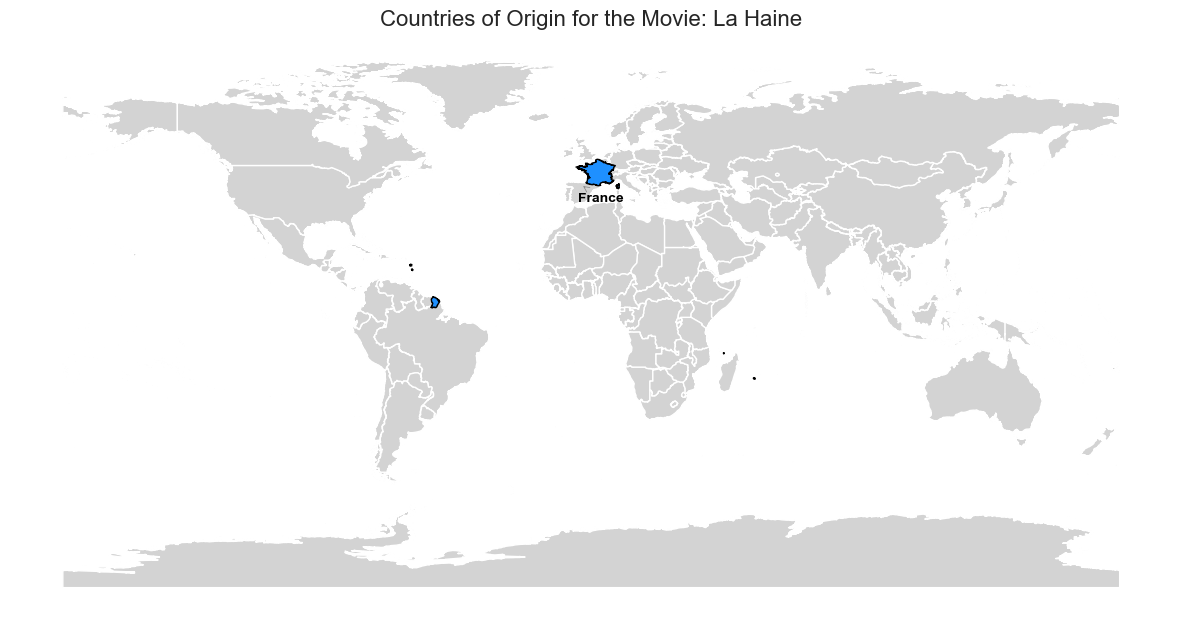

In [460]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
highlighted_countries.plot(ax=ax, color='dodgerblue', edgecolor='black')

for _, row in highlighted_countries.iterrows():
    ax.annotate(
        text=row['NAME'],  # Country name
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        xytext=(row.geometry.centroid.x + 6, row.geometry.centroid.y - 5),
        fontsize=10, color='black', ha='center', fontweight='bold',
        arrowprops=dict(arrowstyle="->", color='grey', lw=0.5)
    )
ax.set_title("Countries of Origin for the Movie: La Haine", fontsize=16)
ax.axis('off')
plt.show()

## How many people worked on this film ?

In [461]:
movie_actors = actor_df[actor_df['id'] == movie_id]
num_actors = movie_actors['name'].nunique()

movie_crew = crew_df[crew_df['id'] == movie_id]
num_crew = movie_crew['name'].nunique()

total_people = num_actors + num_crew

data = pd.DataFrame({
    "Category": ["Actors", "Crew"],
    "Count": [num_actors, num_crew]
})

In [462]:
fig = px.pie(
    data,
    names="Category",
    values="Count",
    title=f"{movie_details['name']} : Actors vs Crew",
    color="Category",
    color_discrete_map={"Actors": "dodgerblue", "Crew": "orange"}
)

fig.add_annotation(
    text=f"Total People Worked: {total_people}",
    x=0.5,
    y=-0.2,
    showarrow=False,
    font=dict(size=14, color="white")
)
fig.show()

Many people worked for this film, I would like to know the role of each one within it.
# Role of crew members in "La Haine"

In [463]:
crew_roles = movie_crew.groupby('role').size().reset_index(name='Count')
la_haine_crew = crew_df[crew_df['id'] == movie_id]

num_crew_members = la_haine_crew['name'].nunique()
total_roles = la_haine_crew.shape[0]

In [464]:
fig2 = px.bar(
    crew_roles,
    x="role",
    y="Count",
    title=f"{movie_details['name']} : {total_roles} Crew Roles ",
    text="Count",
    color="role",
    color_discrete_sequence=px.colors.qualitative.Pastel,
)

fig2.update_traces(textposition="outside")
fig2.update_layout(
    xaxis_title="Crew Role",
    yaxis_title="Number of People",
    showlegend=False,
    xaxis=dict(tickangle=-45 ),
    height=600
)
fig2.show()

In [465]:
print(f"We have {total_roles} roles but only {num_crew} crews. This means that some crew members have more than one role.")

We have 37 roles but only 34 crews. This means that some crew members have more than one role.


### Which people have more than one role and what are their different roles ? 

In [466]:
# Group roles by person for the given movie and filter only people with multiple roles
roles_per_person = la_haine_crew.groupby('name')['role'].apply(list).reset_index()
people_with_multiple_roles = roles_per_person[roles_per_person['role'].apply(len) > 1]

# Use explode to simplify the creation of the DataFrame
multi_roles_df = people_with_multiple_roles.explode('role').reset_index(drop=True)

In [467]:
fig = px.treemap(
    multi_roles_df,
    path=['name', 'role'],
    title=f"People with Multiple Roles in {movie_details['name']}",
    color='name',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data={}
)

fig.update_traces(
    textinfo="label",
    textfont=dict(
        family="Arial",
        size=16,
        color="black"
    ),
    texttemplate="<b>%{label}</b>",
    textposition='middle center'
)

fig.update_layout(
    title_font=dict(size=20, family="Arial"),
    margin=dict(t=50, l=25, r=25, b=25),
    uniformtext=dict(minsize=10, mode='hide'),
    hovermode=False
)

fig.show()

Now I'd like to know a little more about the actors who played in it.
### How many movies have the actors from "La Haine" acted in ?

In [468]:
la_haine_actors = actor_df[actor_df['id'] == movie_id]['name'].unique()
actor_movie_counts = (
    actor_df[actor_df['name'].isin(la_haine_actors)]
    .groupby('name')['id'].nunique()
    .reset_index(name='Number of Movies')
    .sort_values(by='Number of Movies', ascending=False)
)

In [469]:
fig = px.bar(
    actor_movie_counts,
    x='name',
    y='Number of Movies',
    title="Number of Unique Movies Acted in by 'La Haine' Actors",
    text='Number of Movies',
    labels={'name': 'Actor', 'Number of Movies': 'Movies'},
    color='Number of Movies',
    color_continuous_scale='Blues'
)

# Adjust layout to ensure visibility of values and bars
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis=dict(title="Actor", tickangle=-45),
    yaxis=dict(title="Number of Movies"),
    margin=dict(t=50, l=50, r=50, b=100),
    height=600
)
fig.show()

### I want to find out if the top 10 actors with the highest number of films from La Haine have also appeared in other highly-rated movies and calculate the average rating of those movies.

In [470]:
# Sort actors by the number of movies and select the top 10
top_actors = actor_movie_counts.sort_values(by='Number of Movies', ascending=False).head(10)

# Filter actor_df for movies of these top actors
top_actor_names = top_actors['name']
top_actor_movies = actor_df[actor_df['name'].isin(top_actor_names)]

# Merge actor_df with movie_df on 'id' to get movie details and ratings
movies_with_ratings = pd.merge(top_actor_movies, movie_df, on='id', how='inner')
movies_with_ratings = movies_with_ratings[movies_with_ratings['rating'].notna()]

# Calculate the average rating for each actor
average_ratings = (
    movies_with_ratings.groupby('name_x')['rating']
    .mean()
    .reset_index(name='Average Rating')
)

# Merge with top actors and sort by Average Rating (descending)
average_ratings = average_ratings.merge(
    top_actors.rename(columns={'name': 'name_x'}), on='name_x'
).sort_values(by='Average Rating', ascending=False)

In [471]:
fig = px.scatter(
    average_ratings,
    x='Number of Movies',
    y='Average Rating',
    text='name_x',
    title="Top 10 Actors: Number of Movies vs. Average Rating",
    labels={'name_x': 'Actor', 'Average Rating': 'Rating', 'Number of Movies': 'Movies'},
    size='Number of Movies',  # Bubble size represents the number of movies
    color='Average Rating',
    color_continuous_scale='Blues'
)

fig.update_traces(textposition='top center')
fig.update_layout(
    xaxis=dict(title="Number of Movies"),
    yaxis=dict(title="Average Rating"),
    margin=dict(t=50, l=50, r=50, b=50),
    height=600
)

fig.show()


They all played in films with an average rating of between 3 and 3.5, which is pretty decent.

I want to determine whether the release dates are concentrated within a short period or spread across several years across different countries.  
This will help assess whether the movie was a global success or primarily a national hit.
### Analyzing Release Date Patterns

In [472]:
movie_releases_premiere = release_df[(release_df['id'] == movie_id) & (release_df['type'] == 'Premiere')]
movie_releases_premiere = movie_releases_premiere.sort_values(by='date')

In [473]:
fig = px.strip(
    movie_releases_premiere,
    x='date',
    y='country',
    title=f"Premiere Release Chronology for {movie_details['name']}",
    labels={'date': 'Release Date', 'country': 'Country'},
    color='country',  # Assign colors by country
    stripmode='group'  # Group countries with their dates
)

# Customize layout for better readability
fig.update_layout(
    xaxis_title="Release Date",
    yaxis_title="Country",
    height=600,
    margin=dict(t=50, l=50, r=50, b=50),
    showlegend=False  # Hide legend
)

fig.show()


The film took some time to be exported, which shows that it is not a worldwide success despite its high rating.
___

After thoroughly analyzing the details of a specific film, I will now focus on the broader dataset, with a particular emphasis on the countries of origin of the films.
# Where do the movies come from ?
To do this, I'm going to calculate the percentage of films coming from around the world.

In [474]:
# Calculate percentages for each country
country_distribution = country_df['country'].value_counts().reset_index()
country_distribution.columns = ['country', 'film_count']
total_films = country_distribution['film_count'].sum()
country_distribution['percentage'] = (country_distribution['film_count'] / total_films) * 100

To show you the result I've chosen to use 2 methods
## The first method with geopandas :

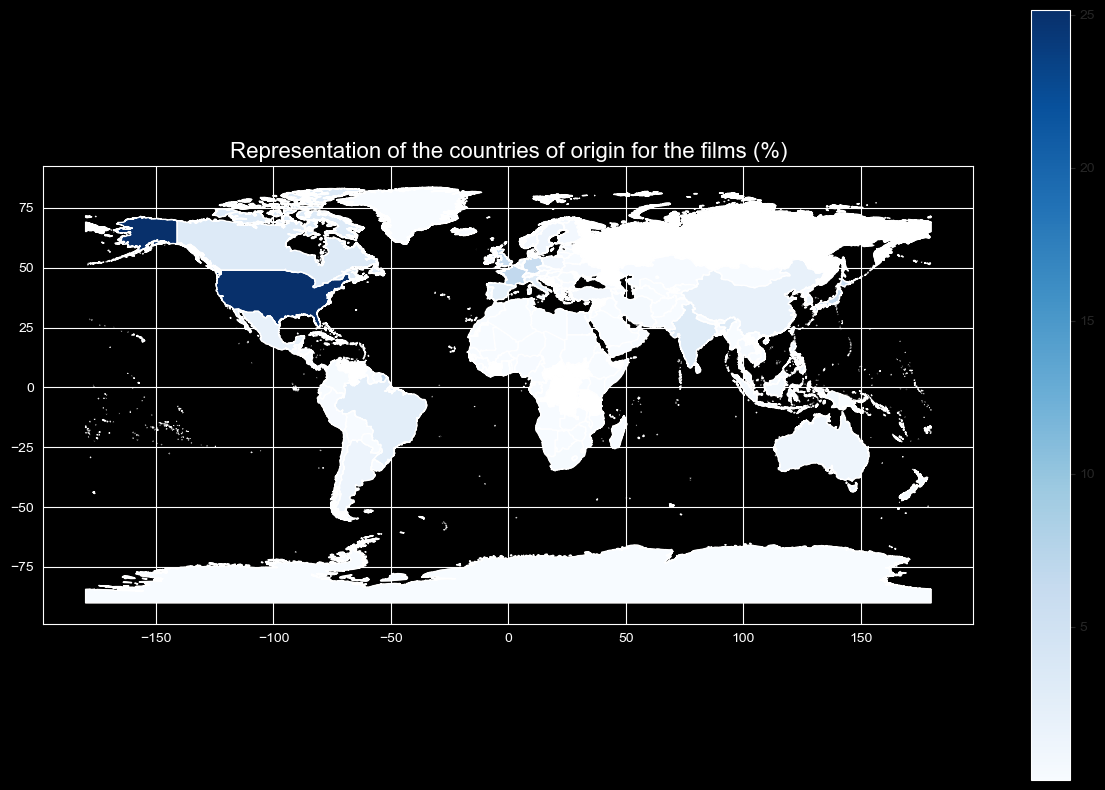

In [475]:
# Step 1: Load the shapefile (replace with your actual shapefile path)
world = gpd.read_file("C:/Users/mathi/Documents/ESIEE/Administratif/ERASMUS_TURIN/Course/3.Web_Services/Project/Notebook/projectNotebook/data/Country Data/ne_10m_admin_0_countries.shp")

# Harmonize country names
country_mapping = {
    'USA': 'United States of America',
    'UK': 'United Kingdom',
}
country_distribution['country'] = country_distribution['country'].replace(country_mapping)

# Merge with GeoPandas data
world = world.merge(country_distribution, left_on='NAME', right_on='country', how='left')

# Get the min and max for the color scale
vmin, vmax = country_distribution['percentage'].min(), country_distribution['percentage'].max()

# Plot the map with a dark background
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="black")
ax.set_facecolor("black")  # Set the axis background to black
world.boundary.plot(ax=ax, linewidth=0.5, edgecolor="white")
world.plot(
    column='percentage',
    ax=ax,
    legend=True,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    missing_kwds={"color": "white", "label": "No data"}
)
ax.set_title("Representation of the countries of origin for the films (%)", fontsize=16, color="white")
ax.tick_params(colors="white")
plt.show()

The chart created with GeoPandas allows for visualizing static data but provides no interactivity or additional information about the data when exploring it.  
That’s why I will create it with Plotly, which offers an interactive and informative experience.
## The second method with plotly

In [476]:
# Create a choropleth map with a dark theme
fig2 = px.choropleth(
    country_distribution,
    locations='country',
    locationmode='country names',
    color='percentage',
    hover_name='country',
    title="Representation of the countries of origin for the films (%)",
    color_continuous_scale='Blues',
    range_color=(vmin, vmax)
)

# Set dark theme and increase figure size
fig2.update_layout(
    template="plotly_dark",
    geo=dict(
        bgcolor="black"
    ),
    width=1200,
    height=800
)

fig2.show()

With so many films coming from all over the world, I'd like to know which languages are most often used in films.
# The most frequently used languages 

In [477]:
# Prepare data for each type
grouped_language = language_df.groupby(['type', 'language']).size().reset_index(name='count')
types = grouped_language['type'].unique()

In [478]:
subplots = make_subplots(
    rows=1, cols=len(types), 
    subplot_titles=types, 
    specs=[[{'type': 'domain'}] * len(types)]
)

# Add a sunburst for each type
for i, t in enumerate(types):
    type_data = grouped_language[grouped_language['type'] == t]
    subplots.add_trace(
        go.Sunburst(
            labels=type_data['language'],
            parents=[''] * len(type_data),
            values=type_data['count'],
            name=t,
            marker=dict(colorscale='Blues')
        ),
        row=1, col=i + 1
    )

# Update layout and adjust figure settings
subplots.update_layout(
    title_text="Distribution of Languages by Type",
    title_font=dict(size=24, color='black'),
    showlegend=False,
    height=600,
    width=1200,
    paper_bgcolor='white',
)

# Update the color of the subplot titles
for annotation in subplots['layout']['annotations']:
    annotation['font'] = dict(size=20, color='black')
    annotation['y'] -= 0.05

subplots.show()

We now know where films come from, what language they speak, but the last thing I want to know is in which country a film is released first. 
# In which country the film is usually released first ?

In [479]:
# Find the first release date and corresponding country for each film
first_release_df = release_df.loc[release_df.groupby('id')['date'].idxmin()]

# Group by country to count the number of times it was the first release
country_first_release = first_release_df['country'].value_counts().reset_index()
country_first_release.columns = ['country', 'count']

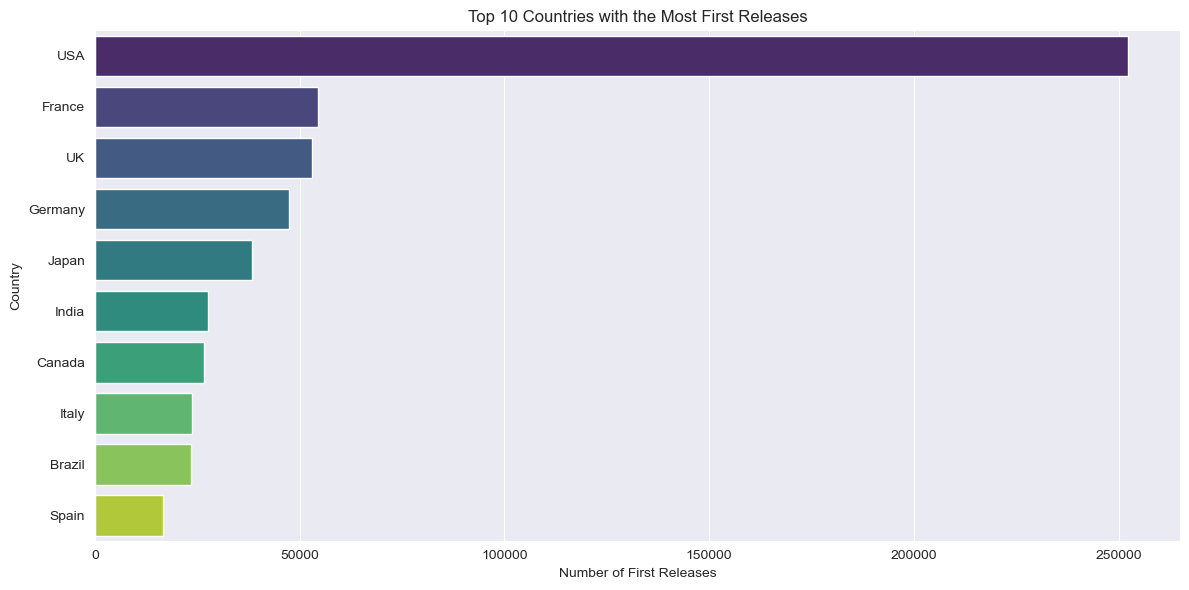

In [480]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='count', y='country', 
    data=country_first_release.head(10),
    palette='viridis',
    hue='country',
    dodge=False
)
plt.legend([], [], frameon=False)
plt.title("Top 10 Countries with the Most First Releases")
plt.xlabel("Number of First Releases")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

So the USA produces the most films, the most widely used language is English, and the first release date in the world is usually in the USA.
So if you're a cinephile, I advise you to move to the USA.
